# Session 2 - Machine Learning (ML) Exploratory Data Analysis

This is an introductory notebook to familiarize yourself with Exploratory Data Analysis techniques for Machine Learning (ML). For this work, we will use data from the Moderate Resolution Imaging Spectroradiometer (MODIS) instrument to test several data science techniques and machine learning algorithms.

Data analytics is now playing a major role in the modern industrial systems and in almost every field of engineering. The power sector is one such arena that generates enormous data especially after the inclusion of the embedded information and networking layer. This paper aims to visualise and analyse the data pertaining to power generation across India. The intent of this paper is three-fold. First an Exploratory Data Analytics(EDA) is conducted to visualise the state-wise data of installed capacity and generated power using different fuels, over a period of eight months. Next, the paper briefly reviews the extent of the private, central, and state sectors in the power industry. Finally, the major issue in the recent times is discussed, viz need of renewable energy sources. A solution to finding out, if a region needs to venture more into the green-energy sources, is proposed using the Random Forest Classification technique in machine learning. The entire work is done using the Python programming language and based on Government uploaded datasets.



Objectives:
- Add objectives

**Author**: Caleb S. Spradlin, Jordan A. Caraballo-Vega  
**Release Date**: 2023.04.08  
**Last Modified**: 2023.04.08  

## 1. Import Libraries

In this section we import the Python libraries to use during the development of this notebook.

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 14.9 MB/s eta 0:00:00


In [ ]:
import os
import sys
import csv
import glob
import joblib
import datasets
import numpy as np
import pandas as pd
from pathlib import Path

# Machine Learning imports
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier as cumlRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Geospatial related imports
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

# Ignore a few warnings for cleaner output
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Define General Variables

In this section we define general variables to work with through this notebook.

In [ ]:
# ddddd
TEST_RATIO = 0.2

# dddd
TILE = 'Golden'

DATASET_URL = 'nasa-cisto-data-science-group/modis-lake-powell-toy-dataset'

# controls random seed for reproducibility
RANDOM_STATE = 42

# column name for label
LABEL_NAME = 'water'

# data type of the label
DATA_TYPE = np.int16

# columns not needed for training
colsToDrop = ['x_offset', 'y_offset', 'year', 'julian_day']

# columns used as features during training
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

Create output directory

In [ ]:
os.makedirs('output', exist_ok=True)

In [ ]:
def load_data(
        fpath: int,
        colsToDrop: list,
        yCol: str = 'water',
        testSize: float = 0.2,
        randomState: int = 42, 
        dataType: np = np.float32,
        cpu: bool = True,
        splitXY: bool = False,
        trainTestSplit: bool = False,
        applyLog: bool = False,
        imbalance: bool = False,
        frac: float = 0.1,
        land: bool = False,
        multi: bool = False, 
        multisample: int = 1000000
    ):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## 3. Data

- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [ ]:
#glob_string = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.1.0/*{}*.parquet.gzip'.format(TILE)
#data_paths = sorted([fv for fv in glob.glob(glob_string)])
#pprint(data_paths)
%%time
dataset = datasets.load_dataset(DATASET_URL, split='train')
df_pandas = pd.DataFrame(dataset)
df_pandas.head()

CPU times: user 306 ms, sys: 10.1 ms, total: 316 ms
Wall time: 829 ms


,water,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
0,0,2031,3113,776,1200,3626,3480,2957,2103,-556,257
1,1,410,494,183,319,295,329,307,929,2004,2334
2,0,1609,2615,797,1000,2143,1708,1107,2381,2098,4051
3,0,2593,3315,1250,1944,3923,4194,3909,1222,-1170,-822
4,0,2485,3365,905,1527,4520,4646,4137,1504,-1599,-1029


In [ ]:
#data_idx = 0
#data_path = data_paths[data_idx]
#os.path.exists(data_path)

## 4. Load in data for use of visualizations 
(skip this if you just want to train model)

In [ ]:
%%time
#df = load_data(fpath=data_path, 
#               colsToDrop=colsToDrop, 
#               splitXY=False, 
#               trainTestSplit=False, 
#               imbalance=False,
#               multi=False)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


In [ ]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   water           800 non-null    int64
 1   sur_refl_b01_1  800 non-null    int64
 2   sur_refl_b02_1  800 non-null    int64
 3   sur_refl_b03_1  800 non-null    int64
 4   sur_refl_b04_1  800 non-null    int64
 5   sur_refl_b05_1  800 non-null    int64
 6   sur_refl_b06_1  800 non-null    int64
 7   sur_refl_b07_1  800 non-null    int64
 8   ndvi            800 non-null    int64
 9   ndwi1           800 non-null    int64
 10  ndwi2           800 non-null    int64
dtypes: int64(11)
memory usage: 68.9 KB


In [ ]:
#df.describe().T.to_csv('output/{}_outputInfo.csv'.format(TILE))
df_pandas.describe().T

,count,mean,std,min,25%,50%,75%,max
water,800.0,0.50625,0.500274,0.0,0.00,1.0,1.00,1.0
sur_refl_b01_1,800.0,1209.75875,1287.886517,8.0,238.25,886.5,1893.25,9222.0
sur_refl_b02_1,800.0,1577.25375,1554.828794,1.0,168.00,1394.0,2667.75,8837.0
sur_refl_b03_1,800.0,743.00000,1004.334475,-100.0,286.00,540.0,857.00,8909.0
sur_refl_b04_1,800.0,1028.39500,1065.582946,6.0,413.00,809.5,1313.25,9162.0
sur_refl_b05_1,800.0,1969.37125,1467.613243,-92.0,553.50,1818.5,3210.75,6382.0
sur_refl_b06_1,800.0,1932.65875,1541.910775,51.0,511.25,1498.5,3254.25,6610.0
sur_refl_b07_1,800.0,1587.69625,1395.266352,0.0,316.75,1174.0,2672.00,6128.0
ndvi,800.0,87.13125,2518.736818,-9493.0,-1533.00,733.5,1729.50,8587.0
ndwi1,800.0,-2336.03750,3404.038705,-9862.0,-4577.50,-1582.0,-766.50,8823.0


In [ ]:
# Get a sample so we can speed up expensive visualizations
sampledDf = df_pandas.sample(frac=0.1)
sampledDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 473 to 552
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   water           80 non-null     int64
 1   sur_refl_b01_1  80 non-null     int64
 2   sur_refl_b02_1  80 non-null     int64
 3   sur_refl_b03_1  80 non-null     int64
 4   sur_refl_b04_1  80 non-null     int64
 5   sur_refl_b05_1  80 non-null     int64
 6   sur_refl_b06_1  80 non-null     int64
 7   sur_refl_b07_1  80 non-null     int64
 8   ndvi            80 non-null     int64
 9   ndwi1           80 non-null     int64
 10  ndwi2           80 non-null     int64
dtypes: int64(11)
memory usage: 7.5 KB


In [ ]:
df_pandas.sample(n=5)

,water,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
208,1,382,311,388,373,306,284,210,-1024,453,1938
284,1,342,379,235,297,896,880,476,513,-3979,-1134
399,1,1479,1488,1276,1491,1367,1357,1193,30,460,1100
669,0,1035,2198,534,824,2549,2301,1656,3597,-228,1406
114,1,1174,1158,1055,1251,1569,1511,1370,-68,-1322,-838


## 5. Exploratory Data Analysis

### 5. 1 Coorelation plots with water points as orange

#### This will take more than 15 mins to run.

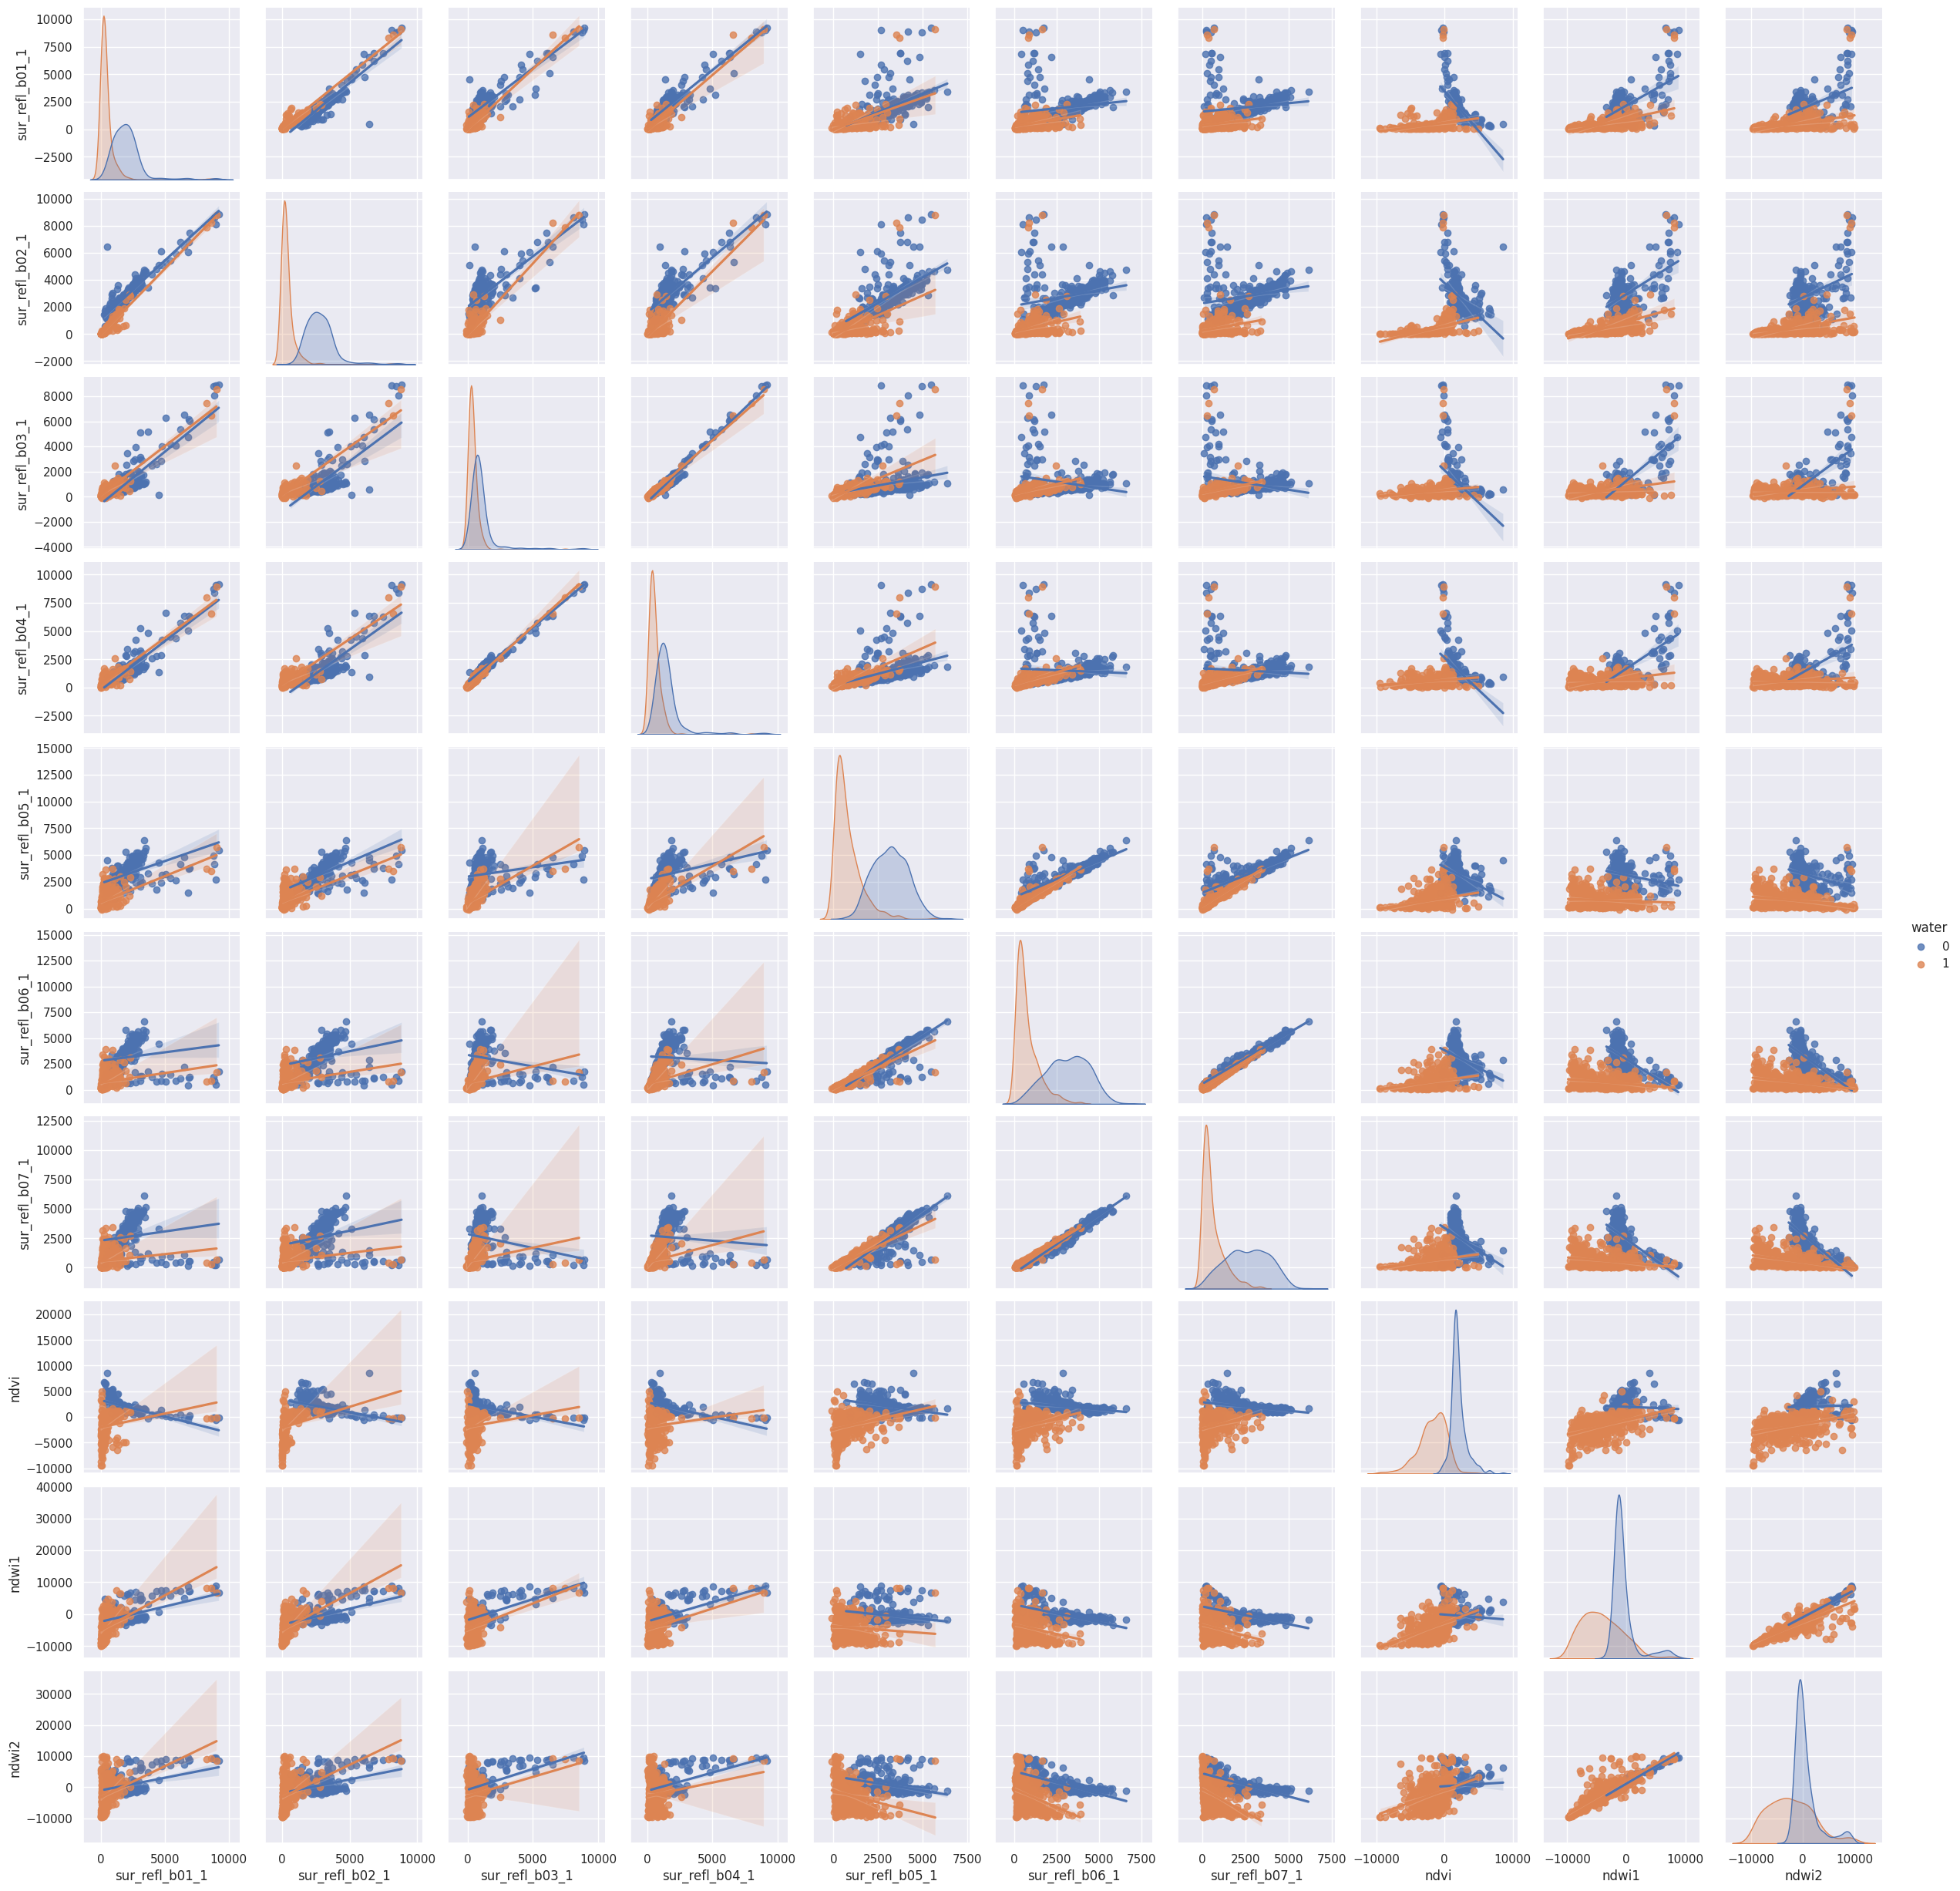

In [ ]:
sns.set()
sns.pairplot(df_pandas, hue='water', kind='reg')
plt.savefig('output/{}_modisWaterTrainingEDA_Correlation_WaterHighlight.png'.format(TILE))

### Distribution for each channel

array([[<Axes: title={'center': 'water'}>,
        <Axes: title={'center': 'sur_refl_b01_1'}>,
        <Axes: title={'center': 'sur_refl_b02_1'}>],
       [<Axes: title={'center': 'sur_refl_b03_1'}>,
        <Axes: title={'center': 'sur_refl_b04_1'}>,
        <Axes: title={'center': 'sur_refl_b05_1'}>],
       [<Axes: title={'center': 'sur_refl_b06_1'}>,
        <Axes: title={'center': 'sur_refl_b07_1'}>,
        <Axes: title={'center': 'ndvi'}>],
       [<Axes: title={'center': 'ndwi1'}>,
        <Axes: title={'center': 'ndwi2'}>, <Axes: >]], dtype=object)

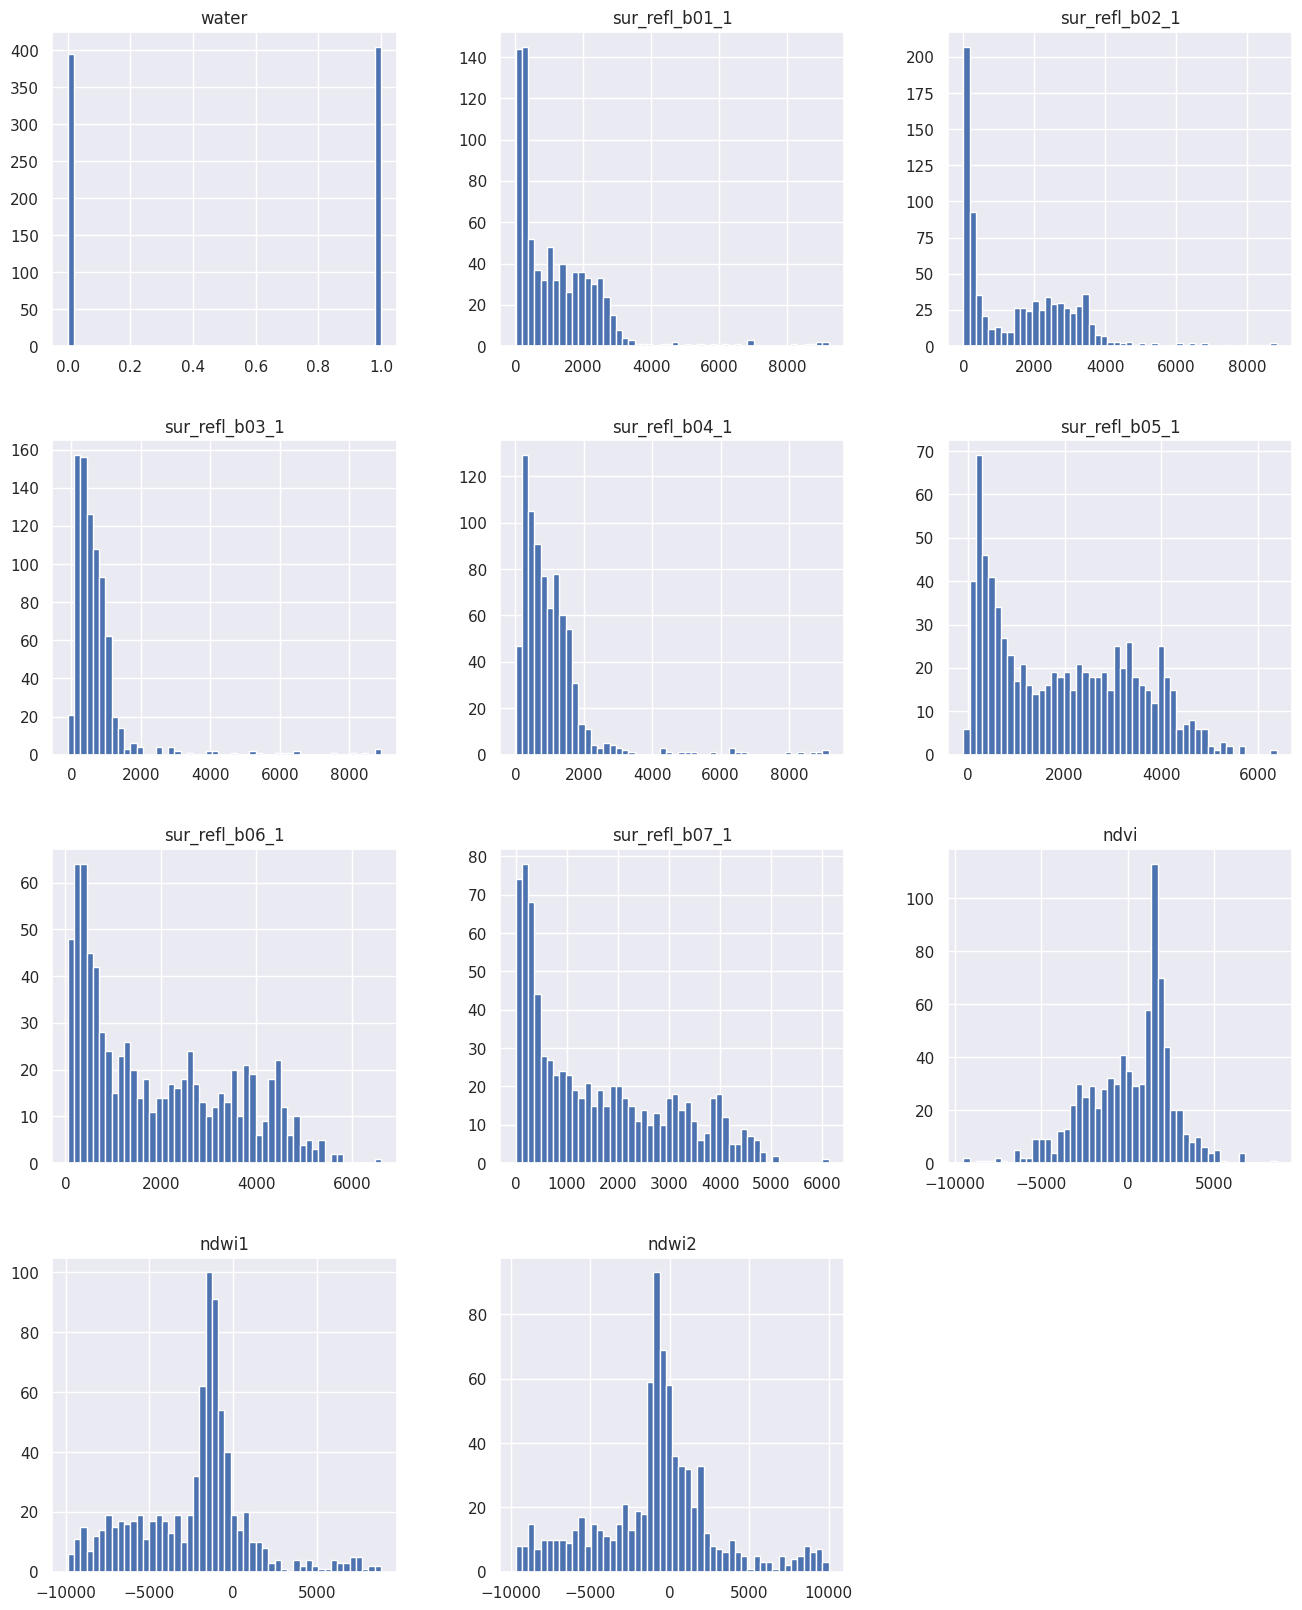

In [ ]:
df_pandas.hist(figsize=(16, 20), bins=50)

### Correlation calculations

In [ ]:
# correlation with dataset - target value
corr = df_pandas.corr()['water']
#corr.to_csv('output/{}_correlation.csv'.format(TILE))
corr

water             1.000000
sur_refl_b01_1   -0.604949
sur_refl_b02_1   -0.780173
sur_refl_b03_1   -0.315886
sur_refl_b04_1   -0.431506
sur_refl_b05_1   -0.813848
sur_refl_b06_1   -0.769546
sur_refl_b07_1   -0.720314
ndvi             -0.751600
ndwi1            -0.536501
ndwi2            -0.382001
Name: water, dtype: float64

In [ ]:
# full correlation table
df_pandas.corr().style.background_gradient(cmap='viridis')

,water,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
water,1.000000,-0.604949,-0.780173,-0.315886,-0.431506,-0.813848,-0.769546,-0.720314,-0.751600,-0.536501,-0.382001
sur_refl_b01_1,-0.604949,1.000000,0.945684,0.857138,0.918364,0.736051,0.555226,0.520304,0.365613,0.644189,0.479509
sur_refl_b02_1,-0.780173,0.945684,1.000000,0.725588,0.814153,0.854383,0.699178,0.653082,0.574397,0.676687,0.499082
sur_refl_b03_1,-0.315886,0.857138,0.725588,1.000000,0.979398,0.447638,0.195292,0.152493,0.148278,0.540643,0.427898
sur_refl_b04_1,-0.431506,0.918364,0.814153,0.979398,1.000000,0.592604,0.365734,0.324536,0.224591,0.547416,0.407715
sur_refl_b05_1,-0.813848,0.736051,0.854383,0.447638,0.592604,1.000000,0.948514,0.919976,0.611504,0.362238,0.163515
sur_refl_b06_1,-0.769546,0.555226,0.699178,0.195292,0.365734,0.948514,1.000000,0.991028,0.571557,0.203993,0.023099
sur_refl_b07_1,-0.720314,0.520304,0.653082,0.152493,0.324536,0.919976,0.991028,1.000000,0.519074,0.156148,-0.038017
ndvi,-0.751600,0.365613,0.574397,0.148278,0.224591,0.611504,0.571557,0.519074,1.000000,0.588516,0.469716
ndwi1,-0.536501,0.644189,0.676687,0.540643,0.547416,0.362238,0.203993,0.156148,0.588516,1.000000,0.890413


## Distributions

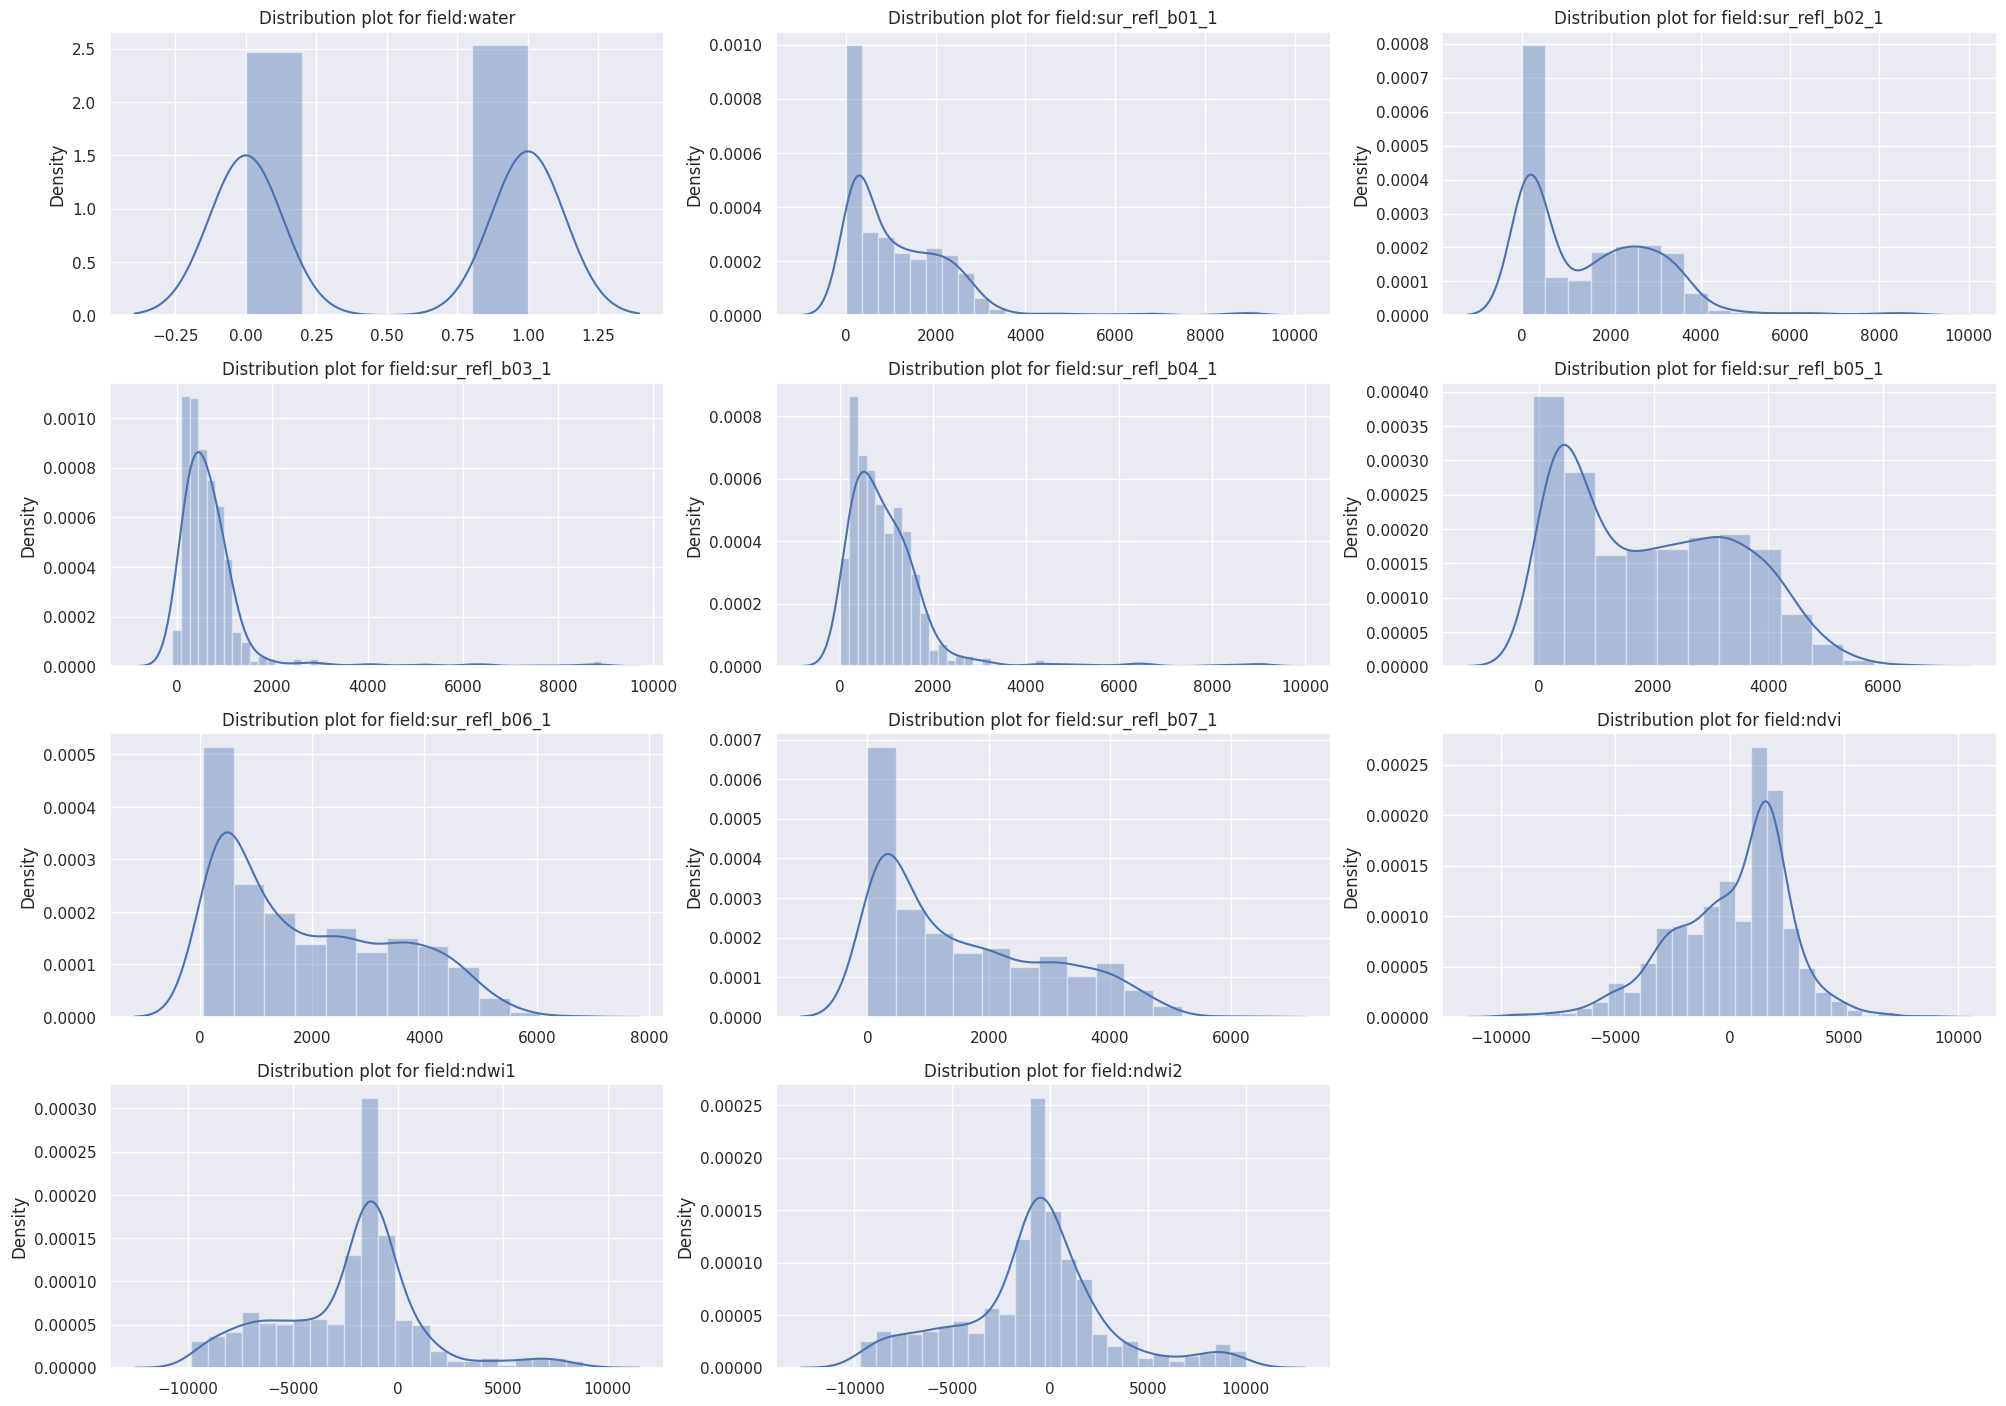

In [ ]:
plt.figure(figsize=(20, 14))

for i, c in enumerate(df_pandas.select_dtypes(include='number').columns):
    plt.subplot(4,3,i+1)
    sns.distplot(df_pandas[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.savefig('output/{}_output_dist_modis_water.png'.format(TILE))

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

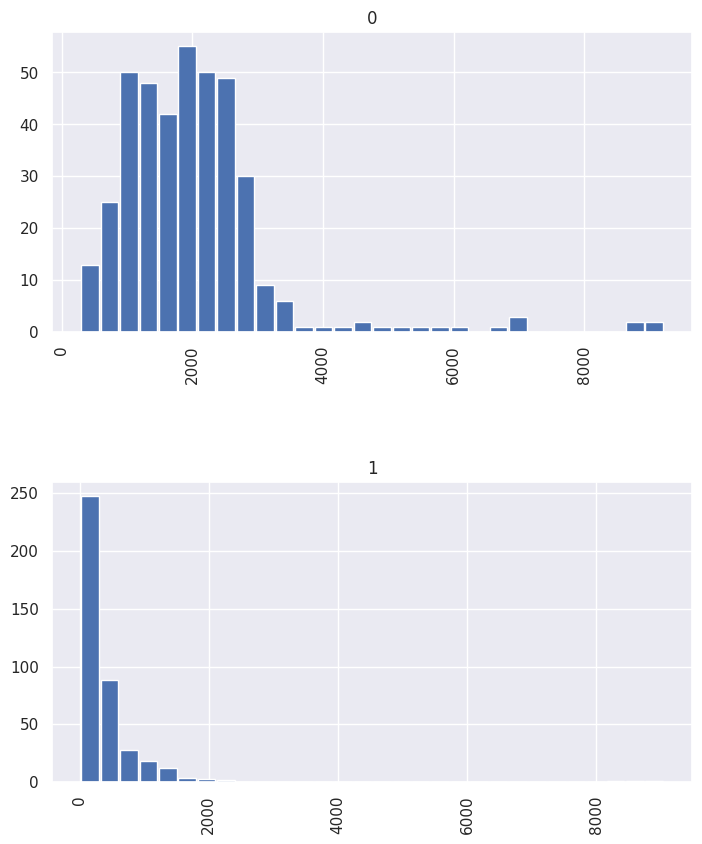

In [ ]:
df_pandas.hist(column='sur_refl_b01_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b01_dist.png'.format(TILE))

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

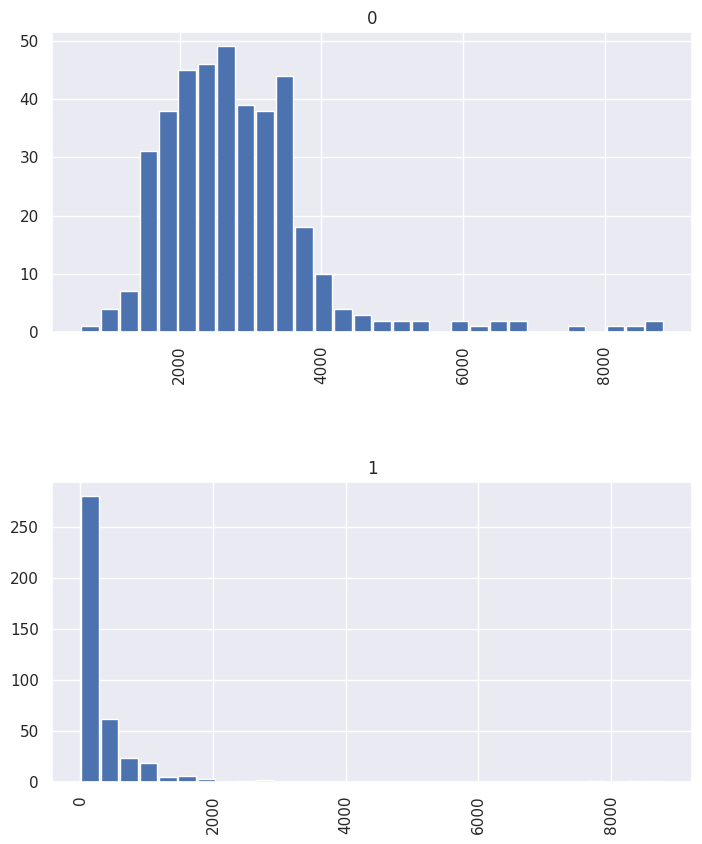

In [ ]:
df_pandas.hist(column='sur_refl_b02_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b02_dist.png'.format(TILE))

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

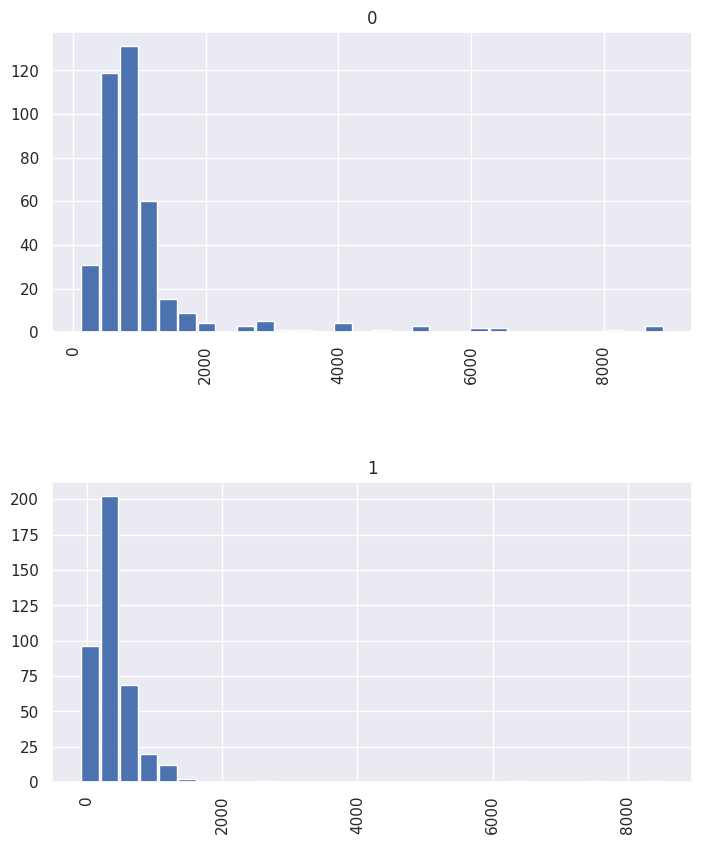

In [ ]:
df_pandas.hist(column='sur_refl_b03_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b03_dist.png'.format(TILE))

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

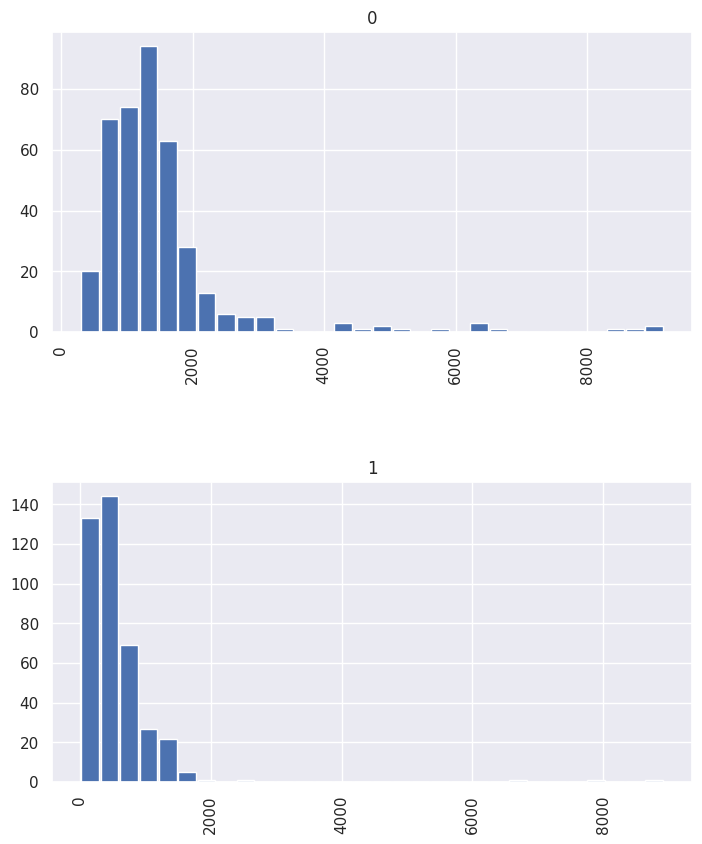

In [ ]:
df_pandas.hist(column='sur_refl_b04_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b04_dist.png'.format(TILE))

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

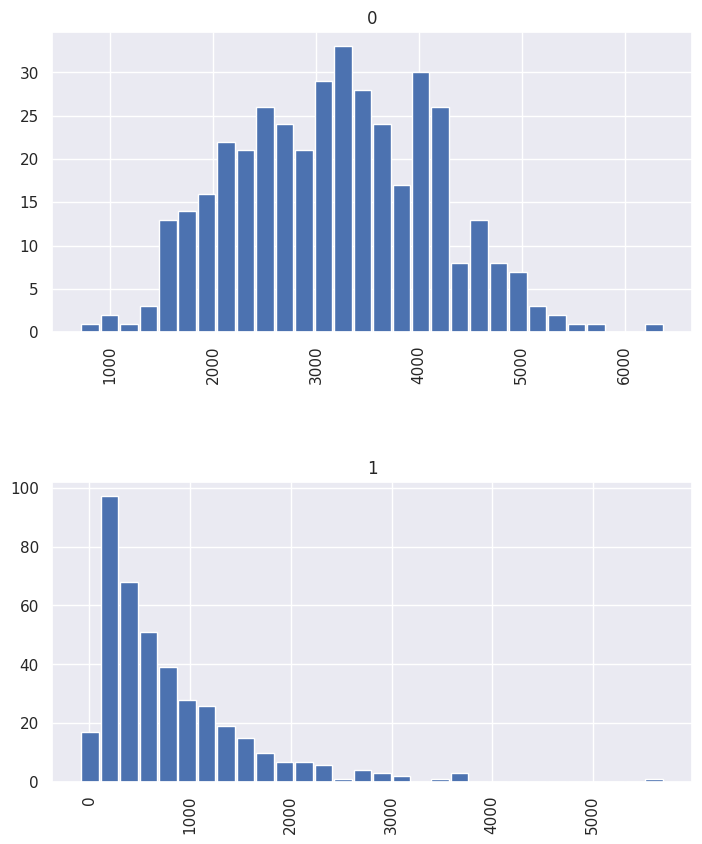

In [ ]:
df_pandas.hist(column='sur_refl_b05_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b05_dist.png'.format(TILE))

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

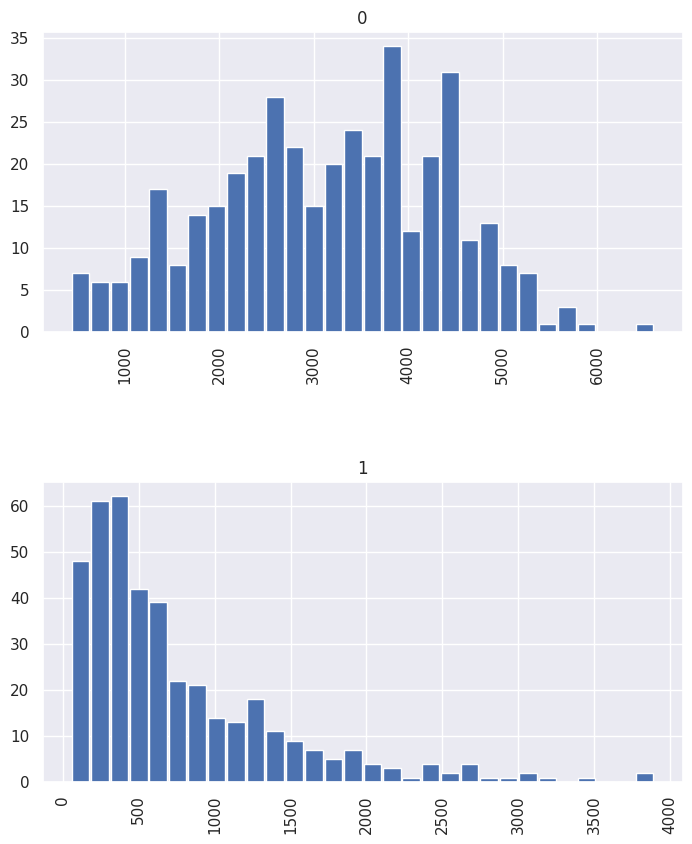

In [ ]:
df_pandas.hist(column='sur_refl_b06_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b06_dist.png'.format(TILE))

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

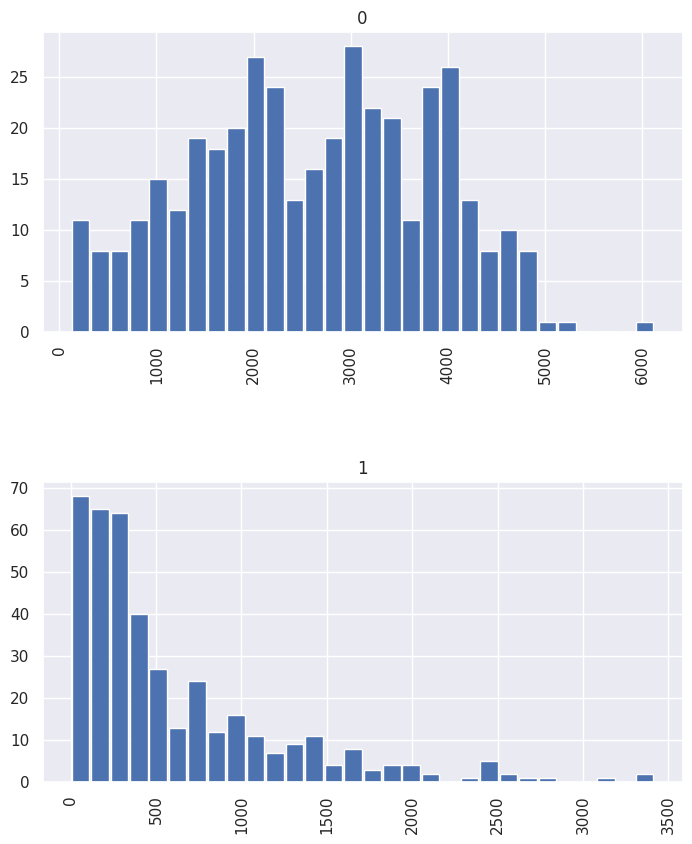

In [ ]:
df_pandas.hist(column='sur_refl_b07_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b07_dist.png'.format(TILE))

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

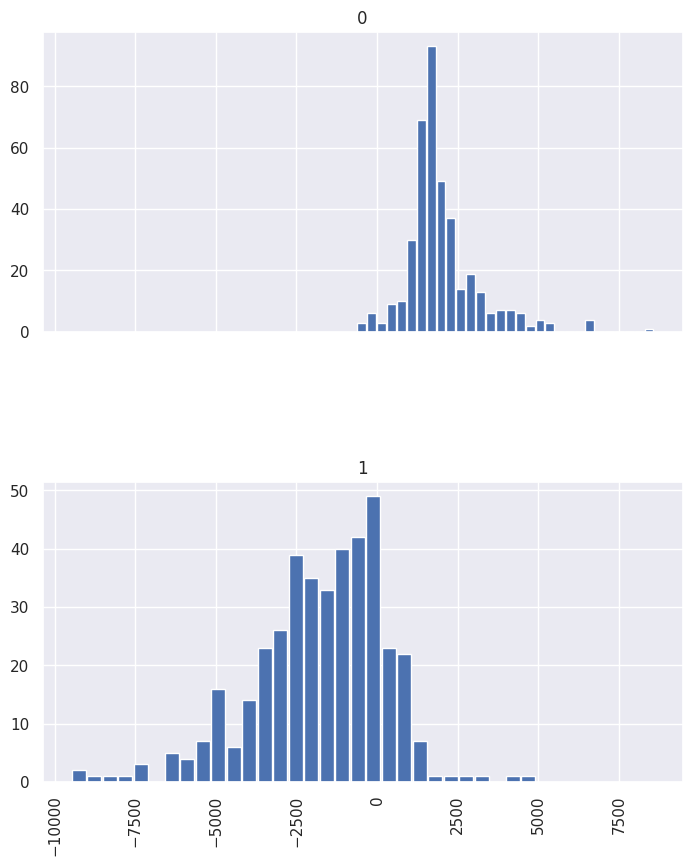

In [ ]:
df_pandas.hist(column='ndvi', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=True)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

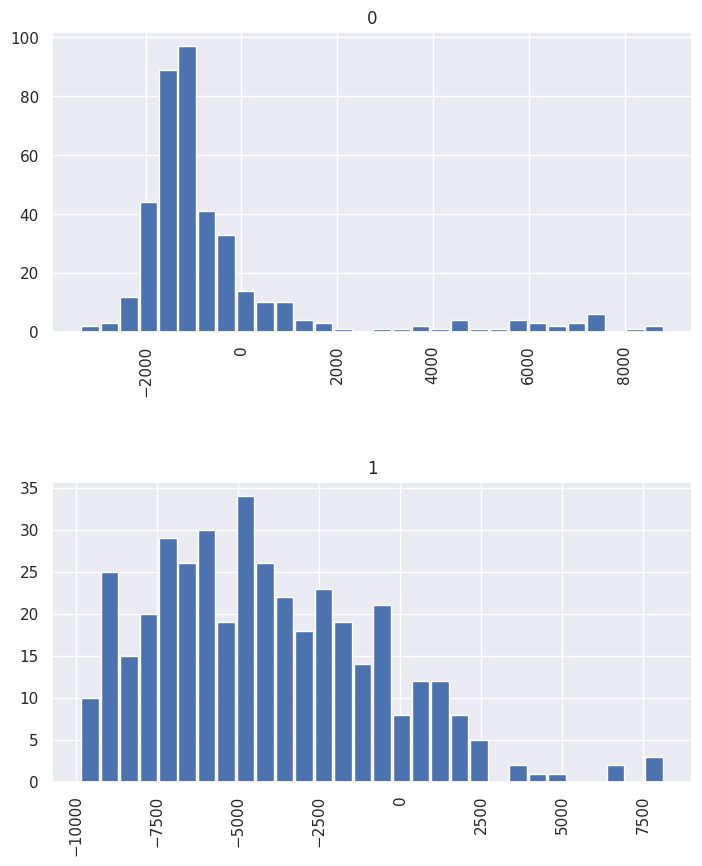

In [ ]:
df_pandas.hist(column='ndwi1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

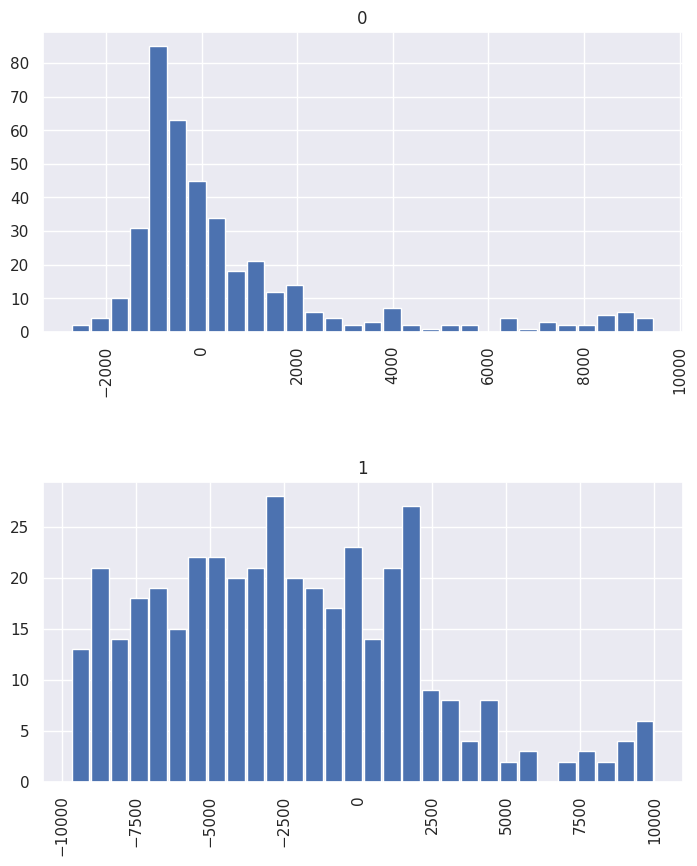

In [ ]:
df_pandas.hist(column='ndwi2', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9)

### Outlier Detection¶

There are so much way to find outlier values. Today we are going to one.

Tukey IQR

In [ ]:
def find_outliers_tukey(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3 - q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x<floor) | (x>ceiling)])
    outlier_values = list(x[outlier_indices])
    
    return outlier_indices,outlier_values

In [ ]:
tukey_indices,tukey_values = find_outliers_tukey(df_pandas['ndwi2'])
np.sort(tukey_values)

array([-9692, -9615, -9607, -9598, -9436, -9413, -9406, -9338, -9282,
       -9246, -9192, -9061, -9057, -9029, -9019, -8954, -8898, -8897,
       -8826, -8809, -8804, -8760, -8671, -8655, -8654, -8621, -8610,
       -8606, -8601, -8592, -8518, -8482, -8468, -8439,  6543,  6865,
        6965,  7083,  7089,  7219,  7328,  7602,  7650,  7714,  7848,
        7977,  8110,  8176,  8309,  8321,  8345,  8486,  8504,  8527,
        8569,  8664,  8669,  8679,  8682,  8918,  8990,  9076,  9093,
        9163,  9210,  9264,  9351,  9372,  9435,  9453,  9459,  9473,
        9848,  9858, 10000])

## Feature Engineering¶


In [ ]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_interactions(df):
    combos = list(combinations(list(df.columns),2))
    colnames = list(df.columns) + ['_'.join(x) for  x in combos]
    
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis= 1)
    
    return df

In [ ]:
df_pandas_expanded = add_interactions(df_pandas)
df_pandas_expanded.head()

,water,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,...,sur_refl_b06_1_sur_refl_b07_1,sur_refl_b06_1_ndvi,sur_refl_b06_1_ndwi1,sur_refl_b06_1_ndwi2,sur_refl_b07_1_ndvi,sur_refl_b07_1_ndwi1,sur_refl_b07_1_ndwi2,ndvi_ndwi1,ndvi_ndwi2,ndwi1_ndwi2
0,0.0,2031.0,3113.0,776.0,1200.0,3626.0,3480.0,2957.0,2103.0,-556.0,...,10290360.0,7318440.0,-1934880.0,894360.0,6218571.0,-1644092.0,759949.0,-1169268.0,540471.0,-142892.0
1,1.0,410.0,494.0,183.0,319.0,295.0,329.0,307.0,929.0,2004.0,...,101003.0,305641.0,659316.0,767886.0,285203.0,615228.0,716538.0,1861716.0,2168286.0,4677336.0
2,0.0,1609.0,2615.0,797.0,1000.0,2143.0,1708.0,1107.0,2381.0,2098.0,...,1890756.0,4066748.0,3583384.0,6919108.0,2635767.0,2322486.0,4484457.0,4995338.0,9645431.0,8498998.0
3,0.0,2593.0,3315.0,1250.0,1944.0,3923.0,4194.0,3909.0,1222.0,-1170.0,...,16394346.0,5125068.0,-4906980.0,-3447468.0,4776798.0,-4573530.0,-3213198.0,-1429740.0,-1004484.0,961740.0
4,0.0,2485.0,3365.0,905.0,1527.0,4520.0,4646.0,4137.0,1504.0,-1599.0,...,19220502.0,6987584.0,-7428954.0,-4780734.0,6222048.0,-6615063.0,-4256973.0,-2404896.0,-1547616.0,1645371.0


## Dimesionality reduction using PCA
PCA is a tecnique that transforms a dataset of many features into pricipal components that summarize the variance that underlies the data

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=66)
X_pca = pd.DataFrame(pca.fit_transform(df_pandas_expanded))
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,-4.310427e+06,-2.158824e+07,8.401862e+06,7.146952e+06,4.377849e+06,1.224151e+06,5.625093e+05,9.313997e+05,-3.226322e+05,-1.724935e+06,...,2.074263,0.358994,-6.713978,0.917685,-1.567924,4.045103,0.135511,-0.108983,0.048881,-0.026456
1,-5.516881e+06,-2.940101e+06,-1.893098e+07,-2.290140e+06,4.510123e+05,4.672985e+05,-1.423265e+06,-2.067000e+06,1.257403e+06,2.070249e+05,...,-21.964011,-70.851753,46.722451,-3.846638,4.287904,8.307211,-0.052840,0.014334,-0.041414,-0.035211
2,1.032742e+07,-5.899496e+06,-1.446940e+07,1.282948e+07,9.420556e+06,1.695662e+06,4.634959e+05,-2.489900e+06,-3.778351e+06,7.057828e+05,...,-22.950894,-14.693588,-29.057870,-16.614984,-0.499390,-4.978857,-0.025569,-0.136995,0.010587,-0.016586
3,-6.167092e+06,-2.380347e+07,2.413577e+07,3.848482e+06,-3.642830e+06,1.996062e+06,-2.668080e+06,-1.161285e+06,-5.238799e+05,5.416549e+05,...,6.003388,12.370099,5.071167,0.776214,3.311614,6.295800,0.244635,0.132292,0.099219,-0.021385
4,-9.299378e+06,-2.497557e+07,3.096599e+07,3.584711e+06,-1.258757e+06,2.176176e+06,7.373333e+05,-5.441353e+05,2.067818e+06,2.181068e+05,...,25.504095,12.020508,4.124412,7.710674,0.761796,0.072756,-0.026081,0.399976,-0.060216,-0.033019
